# Synthetic data generation

In this notebook, we will generate synthetic data with perturbation of cell type abundance and/or gene expression. It will help us to understand what different patient representation method pay attention to. We will use the [PBMC3k dataset](https://scanpy-tutorials.readthedocs.io/en/multiomics/pbmc3k.html) for this purpose. It has peripheral blood mononuclear cells from 3k cells of a healthy donor. We will simulate synthetic donors perturbing hallmarks of severe COVID-19 described in the [COMBAT study](https://pmc.ncbi.nlm.nih.gov/articles/PMC8776501).

Perturbations can happen in two ways:
- **Composition shift** - cells have a similar expression profile but samples have different cell type abundance depending on the severity of the disease.
- **Expression shift** - samples have a similar cell type abundance but different expression profile depending on the severity of the disease.
- **Jointly** - both composition and expression are perturbed depending on the severity of the disease

Here, we'll simulate all 3 cases.

In [1]:
import warnings

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from patient_representation.datasets.synthetic import simulate_data, covid_19_hallmarks, process_adata

warnings.filterwarnings("ignore")

The data can be loaded from the Scanpy package. We will take cell types from the processed data, but will use the original data to work with raw gene expression.

In [2]:
processed_adata = sc.datasets.pbmc3k_processed()
adata = sc.datasets.pbmc3k()
adata = adata[processed_adata.obs_names]
adata.obsp = processed_adata.obsp  # Copy distances to further use nearest neighbors
cell_type_key = "louvain"
adata.obs[cell_type_key] = processed_adata.obs[cell_type_key]

Some of the hallmarks for COVID-19 can be imported from the `patient_representation.datasets.synthetic` module. They contain cell types and genes that are affected by the disease.

In [3]:
severe_covid_19_abundance_hallmarks, severe_covid_19_expression_hallmarks = covid_19_hallmarks()

In [4]:
severe_covid_19_abundance_hallmarks

{'FCGR3A+ Monocytes': 0.4,
 'Dendritic cells': 0.2,
 'CD14+ Monocytes': 2,
 'CD8 T cells': 0.5,
 'NK cells': 4}

In [5]:
severe_covid_19_expression_hallmarks

{'CD4 T cells': {'IFITM1': 0.5, 'ID3': 26.666666666666668, 'TUBA1B': 0.55},
 'CD8 T cells': {'MT-CO1': 5.5, 'GNLY': 0.25},
 'NK cells': {'S1PR1': 15.866666666666667},
 'B cells': {'TXNIP': 0.42},
 'CD14+ Monocytes': {'S100A8': 7.666666666666666,
  'HLA-DQA1': 0.125,
  'CLU': 220.85651708616052,
  'FAM20A': 206.06641683730044,
  'PIM3': 13.333333333333334,
  'CYP19A1': 228.64500534107583,
  'PIM1': 46.42936337579328,
  'CDKN2D': 6.666666666666667,
  'CDIP1': 0.2871745887492587,
  'CACNA2D3': 0.0625,
  'ZNF217': 0.6597539553864471,
  'ZNF703': 0.125,
  'ADAMTS5': 0.03125,
  'HLA-DQA2': 0.03589682359365735}}

Let's take highly variable genes from the processed datasets and add perturbed genes to the list

In [6]:
perturbed_genes = []

for cell_type, degs in severe_covid_19_expression_hallmarks.items():
    perturbed_genes.extend(degs.keys())

genes_to_keep = processed_adata.var_names.tolist() + [g for g in perturbed_genes if g not in processed_adata.var_names]

adata.raw = adata
adata = adata[:, genes_to_keep]

Not all hallmarks genes are highly expressed in the PBMC3k data, so let's add some random genes as well. We'll perturb them in B cells as abundant class but not very well covered in the dictionary above.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


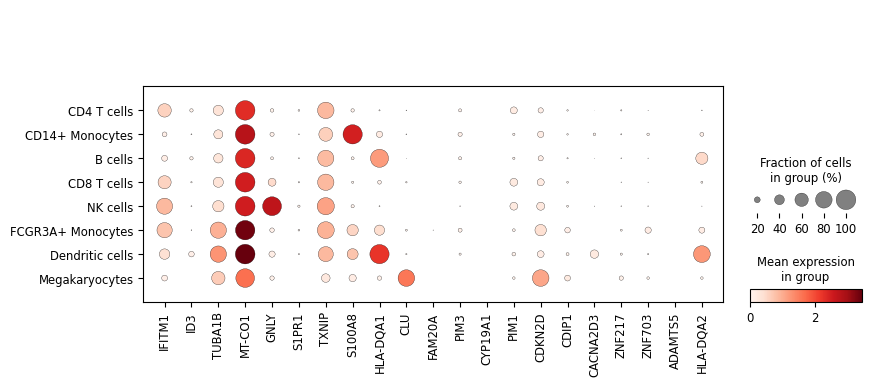

In [7]:
# To select highly expressed genes
sc.pp.calculate_qc_metrics(adata, inplace=True)

n_effected_genes = 16
affected_cell_type = "B cells"

expressed_genes = adata.var_names[adata.var["pct_dropout_by_counts"] < 80]

downregulated_genes = np.random.choice(expressed_genes, size=n_effected_genes // 2)
upregulated_genes = np.random.choice(expressed_genes[~np.isin(expressed_genes, downregulated_genes)], size=n_effected_genes // 2)

for gene in downregulated_genes:
    severe_covid_19_expression_hallmarks[affected_cell_type][gene] = np.random.uniform(0.01, 0.2)

for gene in upregulated_genes:
    severe_covid_19_expression_hallmarks[affected_cell_type][gene] = np.random.uniform(2, 128) / 0.3  # Considering dropout, let's make effect size even more than expected

sc.pl.dotplot(adata, perturbed_genes, groupby=cell_type_key, log=True)


Let's now simulate 3 scenarios with different perturbation types: 
- **Composition shift** - cells have a similar expression profile but samples have different cell type abundance depending on the severity of the disease defined by the perturbation strength.
- **Expression shift** - samples have a similar cell type abundance but different expression profile depending on the severity of the disease.
- **Jointly** - both composition and expression are perturbed depending on the severity of the disease

In [8]:
adata.obs["perturbation_strength"] = 0

n_samples = 40

composition_perturbed_adatas = []
expression_perturbed_adatas = []
jointly_perturbed_adatas = []

for perturbation_strength in np.linspace(0, 1, n_samples):
    print(f"Simulating data with perturbation strength {perturbation_strength}")
    perturbed_adata = adata.copy()
    perturbed_adata.obs["perturbation_strength"] = perturbation_strength

    print("Simulating composition perturbation")
    composition_perturbed_adatas.append(
        simulate_data(perturbed_adata.copy(), cell_type_key, abundance_perturbation=severe_covid_19_abundance_hallmarks, gene_perturbation=None, perturbation_strength=perturbation_strength, expression_noise_scale=1)
    )
    print("Simulating expression perturbation")
    expression_perturbed_adatas.append(
        simulate_data(perturbed_adata.copy(), cell_type_key, abundance_perturbation=None, gene_perturbation=severe_covid_19_expression_hallmarks, perturbation_strength=perturbation_strength, expression_noise_scale=1)
    )
    print("Simulating jointly perturbation")
    jointly_perturbed_adatas.append(
        simulate_data(perturbed_adata.copy(), cell_type_key, abundance_perturbation=severe_covid_19_abundance_hallmarks, gene_perturbation=severe_covid_19_expression_hallmarks, perturbation_strength=perturbation_strength, expression_noise_scale=1)
    )
    print("-" * 100, end="\n\n")

composition_perturbed_adata = sc.concat(composition_perturbed_adatas, axis=0)
expression_perturbed_adata = sc.concat(expression_perturbed_adatas, axis=0)
jointly_perturbed_adata = sc.concat(jointly_perturbed_adatas, axis=0)

composition_perturbed_adata.obs["perturbation_type"] = "composition"
expression_perturbed_adata.obs["perturbation_type"] = "expression"
jointly_perturbed_adata.obs["perturbation_type"] = "joint"

Simulating data with perturbation strength 0.0
Simulating composition perturbation
Simulating expression perturbation
Simulating jointly perturbation
----------------------------------------------------------------------------------------------------

Simulating data with perturbation strength 0.02564102564102564
Simulating composition perturbation
Simulating expression perturbation
Simulating jointly perturbation
----------------------------------------------------------------------------------------------------

Simulating data with perturbation strength 0.05128205128205128
Simulating composition perturbation
Simulating expression perturbation
Simulating jointly perturbation
----------------------------------------------------------------------------------------------------

Simulating data with perturbation strength 0.07692307692307693
Simulating composition perturbation
Simulating expression perturbation
Simulating jointly perturbation
----------------------------------------------

Quickly process the data to make it ready for the analysis. The function `process_adata` will normalize the data, do log transformation, scale the expression, calculate PCA, UMAP and neighbors following the [standard scanpy pipeline](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html).

As we have a lot of samples, the processing will take some time and can require a lot of memory. If your machine struggles with it, you can decrease the number of samples or work with different perturbations one by one.

In [9]:
composition_perturbed_adata = process_adata(composition_perturbed_adata)
expression_perturbed_adata = process_adata(expression_perturbed_adata)
jointly_perturbed_adata = process_adata(jointly_perturbed_adata)

Let's see what the simulated data looks like! Note the presence of **disease-specific cell states** for CD14+ Monocytes and B cells when expression is perturbed (groups of cells with purple color and no blue in between). The composition shift is easier to spot by looking at NK cells: there are more of them in the composition perturbed data.


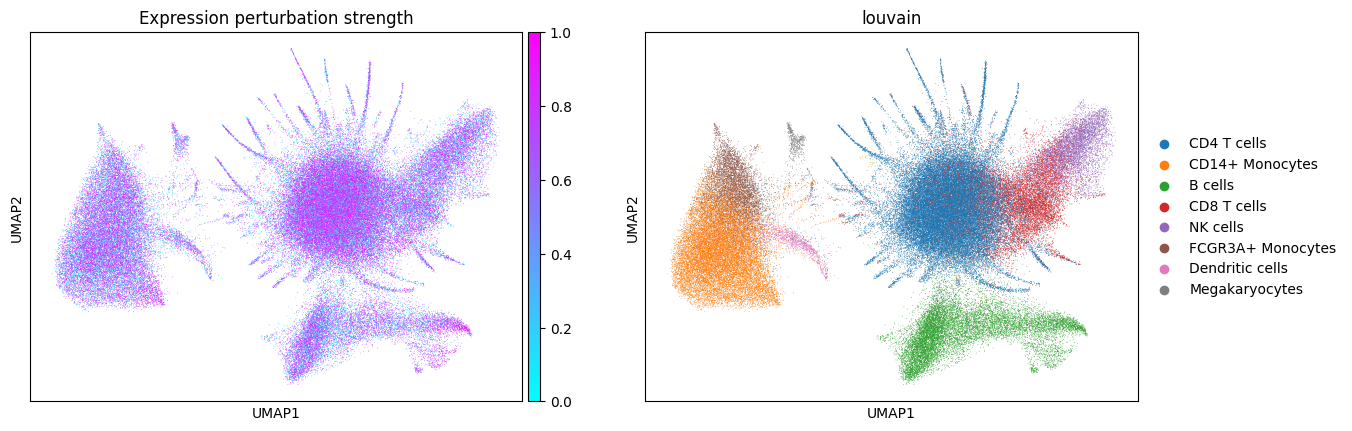

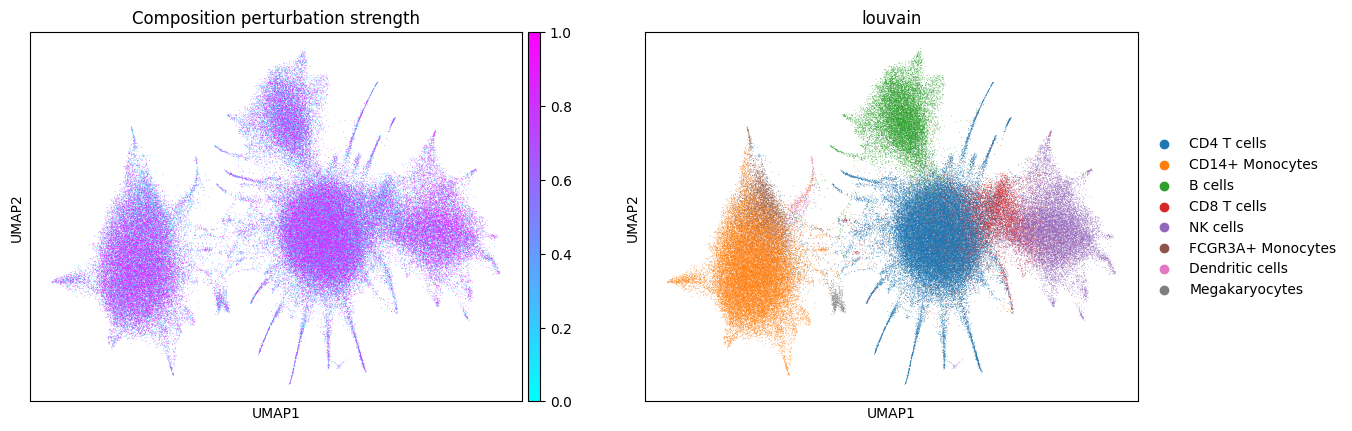

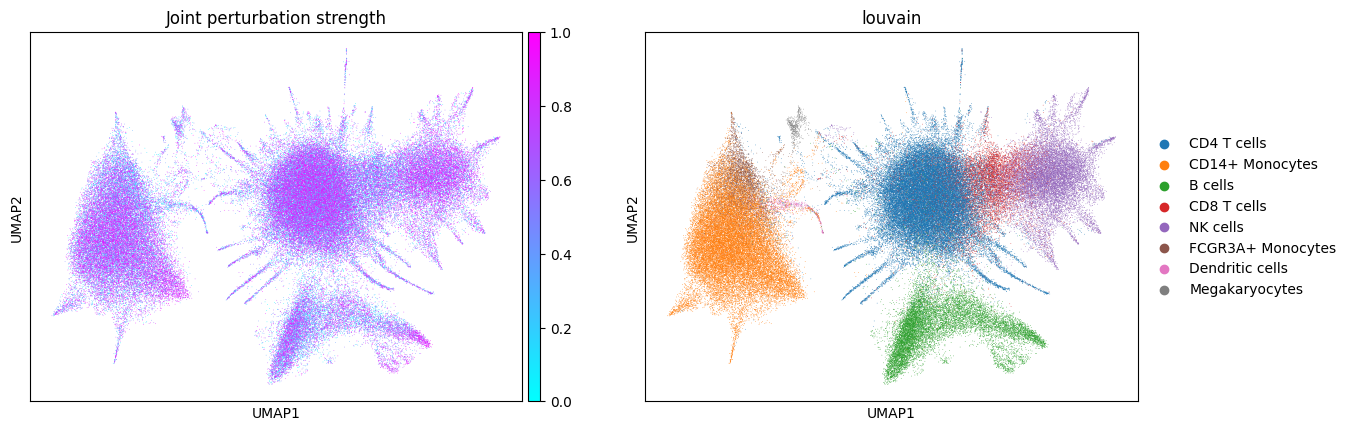

In [10]:
cols_to_plot = ["perturbation_strength", cell_type_key]

sc.pl.umap(expression_perturbed_adata, color=cols_to_plot, title="Expression perturbation strength", cmap="cool")
sc.pl.umap(composition_perturbed_adata, color=cols_to_plot, title="Composition perturbation strength", cmap="cool")
sc.pl.umap(jointly_perturbed_adata, color=cols_to_plot, title="Joint perturbation strength", cmap="cool")

In composition perturbation cell type abundances change linearly with the perturbation strength:

<Axes: xlabel='perturbation_strength'>

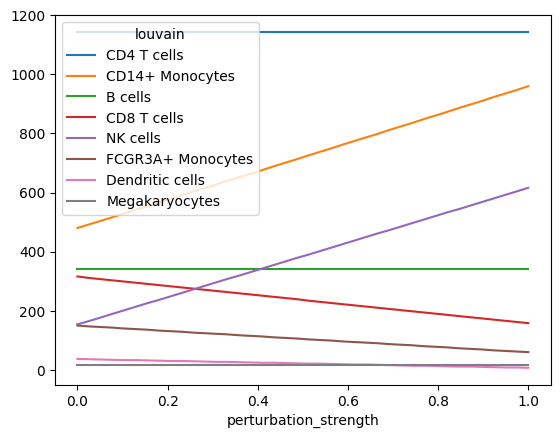

In [11]:
pd.crosstab(
    composition_perturbed_adata.obs["perturbation_strength"], composition_perturbed_adata.obs[cell_type_key]
).plot.line()

We can also see how genes are perturbed in the expression perturbation:

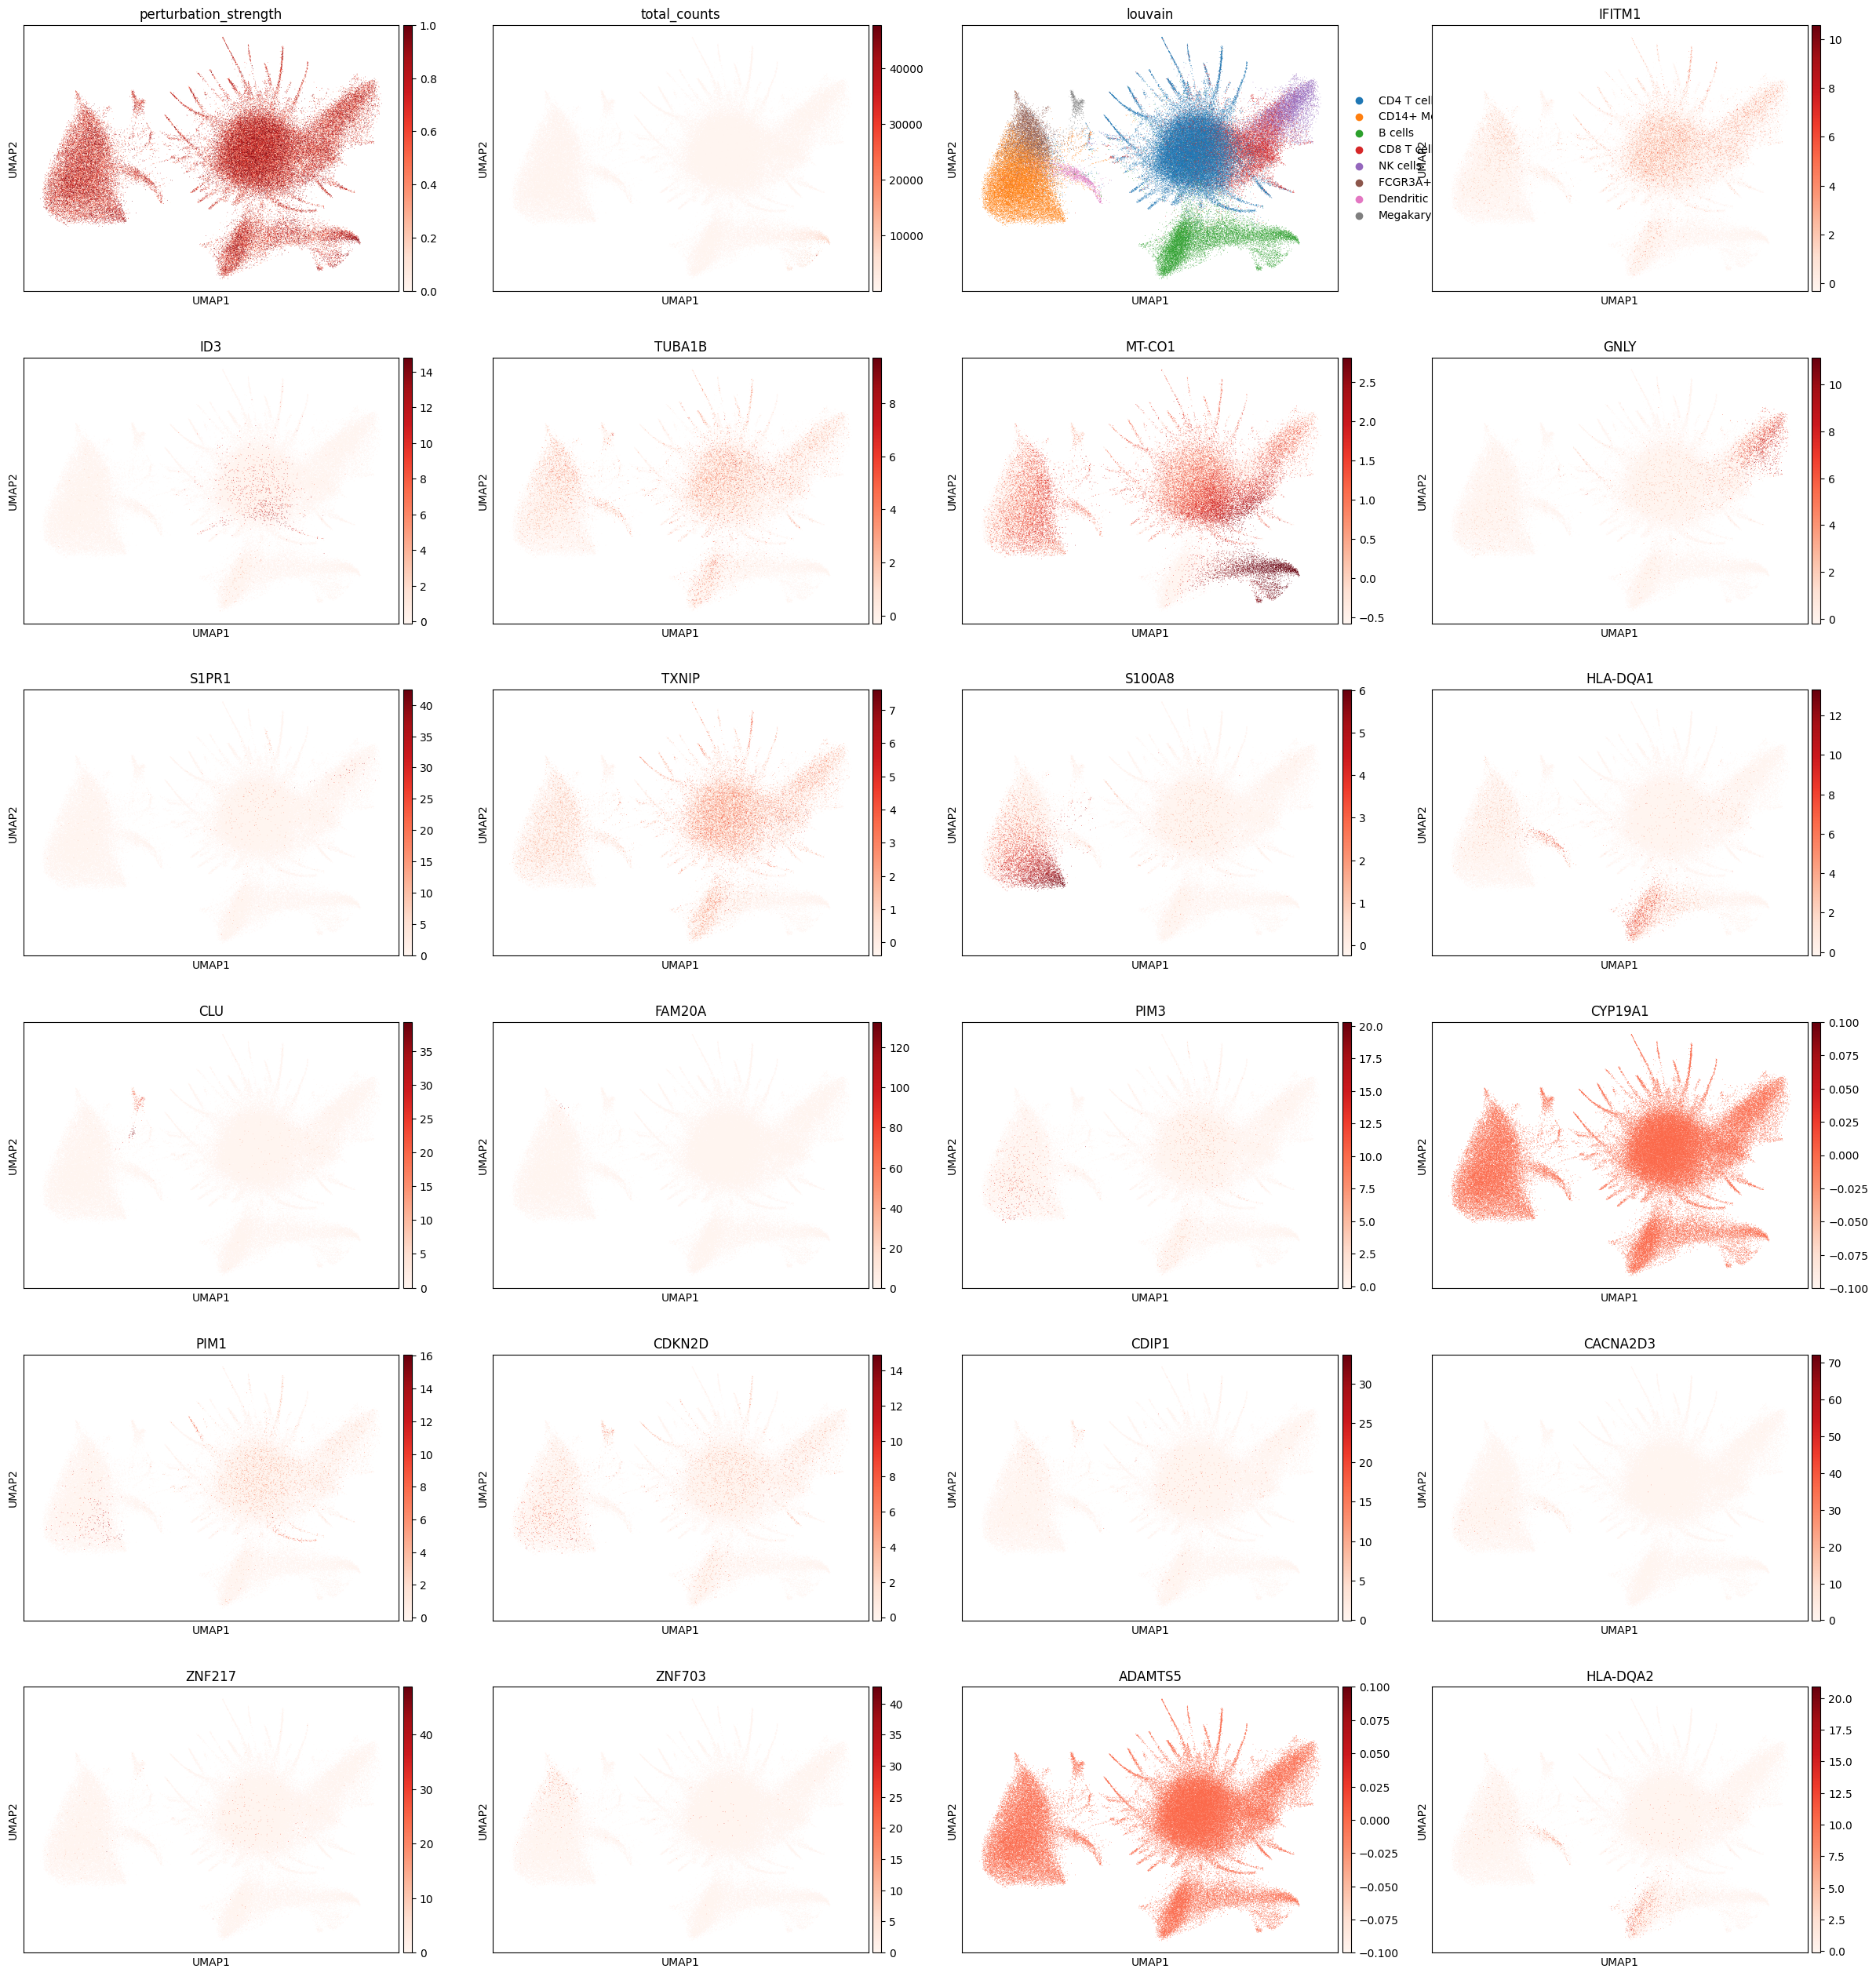

In [12]:
sc.pl.umap(expression_perturbed_adata, color=["perturbation_strength", "total_counts", cell_type_key] + perturbed_genes, cmap="Reds")

The jointly perturbed data has a combination of the composition and expression perturbations

## Patient representation analysis

Let's explore how simple patient representation methods work on the simulated data. We will start with **pseudobulking**  and **composition** differences. Intuitively, pseudobulking should capture both composition and expression shift effects, while composition differences should only capture composition shift.

In [13]:
import patient_representation as pr

In [14]:
composition_perturbed_adata.obs["sample_key"] = "sample_" + composition_perturbed_adata.obs["perturbation_strength"].astype(str)
expression_perturbed_adata.obs["sample_key"] = "sample_" + expression_perturbed_adata.obs["perturbation_strength"].astype(str)
jointly_perturbed_adata.obs["sample_key"] = "sample_" + jointly_perturbed_adata.obs["perturbation_strength"].astype(str)


0 samples removed: 
0 cell types removed: 


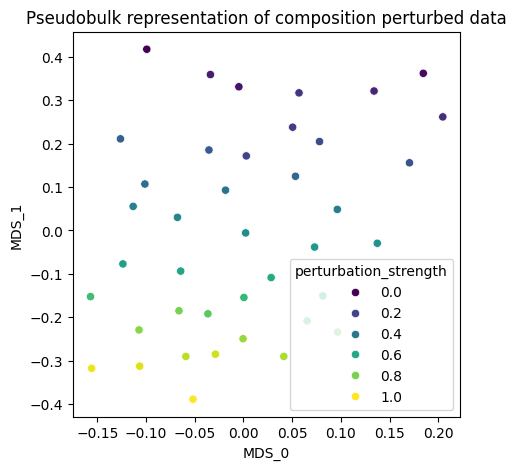

0 samples removed: 
0 cell types removed: 


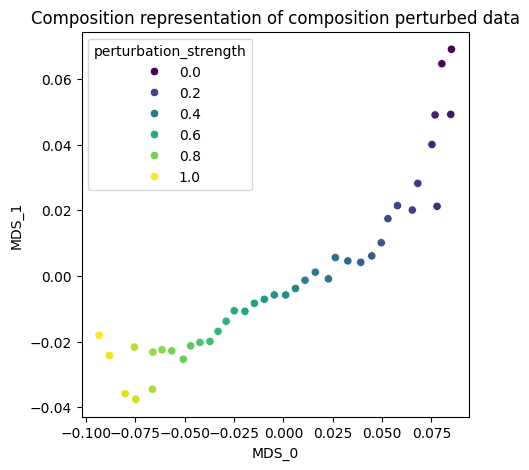

0 samples removed: 
0 cell types removed: 


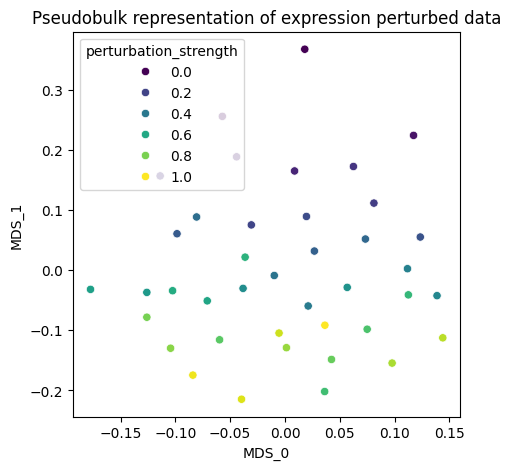

0 samples removed: 
0 cell types removed: 


/Users/vladimir.shitov/miniconda3/envs/patients_representation/lib/python3.10/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/Users/vladimir.shitov/miniconda3/envs/patients_representation/lib/python3.10/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/Users/vladimir.shitov/miniconda3/envs/patients_representation/lib/python3.10/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/Users/vladimir.shitov/miniconda3/envs/patients_representation/lib/python3.10/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/Users/vladimir.shitov/miniconda3/envs/patients_representation/lib/python3.10/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: i

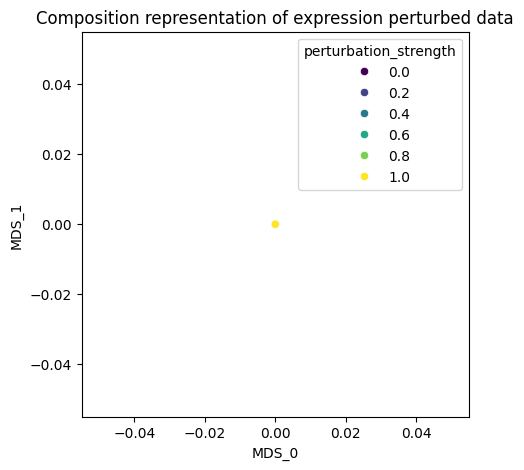

0 samples removed: 
0 cell types removed: 


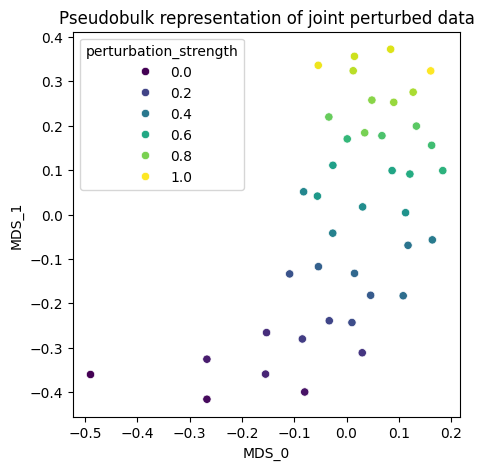

0 samples removed: 
0 cell types removed: 


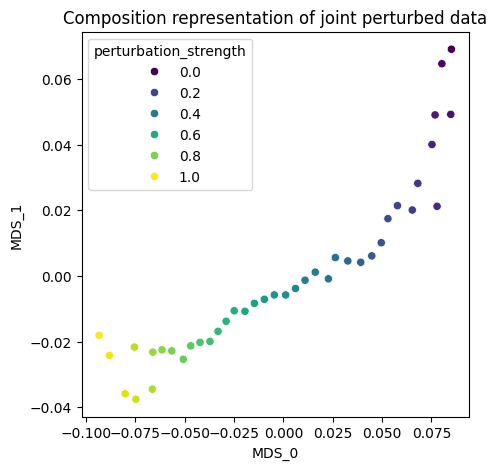

In [15]:
for perturbed_adata in [composition_perturbed_adata, expression_perturbed_adata, jointly_perturbed_adata]:
    pseudobulk = pr.tl.TotalPseudobulk("sample_key", cell_type_key)
    pseudobulk.prepare_anndata(perturbed_adata)
    pseudobulk.calculate_distance_matrix()
    ax = pseudobulk.plot_embedding("MDS", metadata_cols=["perturbation_strength"])
    ax.set_title("Pseudobulk representation of " + perturbed_adata.obs["perturbation_type"][0] + " perturbed data")
    plt.show()

    composition = pr.tl.CellTypesComposition("sample_key", cell_type_key)
    composition.prepare_anndata(perturbed_adata)
    composition.calculate_distance_matrix()
    ax = composition.plot_embedding("MDS", metadata_cols=["perturbation_strength"])
    ax.set_title("Composition representation of " + perturbed_adata.obs["perturbation_type"][0] + " perturbed data")
    plt.show()

As we can see, pseudobulking captures both composition and expression shift effects, while composition differences only capture composition shift. Joint perturbation is captured well by both methods. We can evaluate it by predicting perturbation strength (disease severity) from the representation:

In [16]:
pseudobulk.evaluate_representation(target="perturbation_strength", task="regression")

{'score': 0.9849906191369607,
 'metric': 'spearman_r',
 'n_unique': 40,
 'n_observations': 40,
 'method': 'knn'}

In [17]:
composition.evaluate_representation(target="perturbation_strength", task="regression")

{'score': 0.998874296435272,
 'metric': 'spearman_r',
 'n_unique': 40,
 'n_observations': 40,
 'method': 'knn'}

In [22]:
expression_perturbed_adata.write("../../docs/notebooks/data/synthetic_expression_perturbed.h5ad")
composition_perturbed_adata.write("../../docs/notebooks/data/synthetic_composition_perturbed.h5ad")
jointly_perturbed_adata.write("../../docs/notebooks/data/synthetic_jointly_perturbed.h5ad")